### Installs the Required Dependencies


In [1]:
!pip install -U pandas
!pip install -U matplotlib

!pip install nx-arangodb
!pip install arango-datasets

# Requires Nividia GPU
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com 


!pip install google-genai
!pip install langchain-openai
!pip install langchain-mistralai

!pip install langchain
!pip install langchain-google-genai
!pip install -U langchain-community
!pip install langgraph

!pip install python-louvain
!pip install tabulate
!pip install folium
!pip install ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 77.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstall

### Imports the packages


In [2]:
# Import required modules
import json
import os
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Tuple, Literal, Union, Any
from typing_extensions import Annotated, TypedDict
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate
import pprint
import re
import shutil
from IPython.display import display, display_html
import folium



import networkx as nx
import nx_arangodb as nxadb
from pathlib import Path  

# Requires Nvidia GPU
import cudf
import cugraph as cg


from arango import ArangoClient
from arango_datasets import Datasets
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain.chains import ArangoGraphQAChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain.chains import ArangoGraphQAChain





# Gemini SDK Packages
from google import genai

# OpenAI SDK Packages
from openai import OpenAI

[04:19:02 +0000] [INFO]: NetworkX-cuGraph is available.


### Cuda and GPU Info

In [3]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Mon Mar 10 04:19:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8      

### Loads the env variables and configure the networkX backend


In [5]:
"""---------- .env example ----------"""
# %env ARANGO_HOST = YOUR_ARANGO_HOST
# %env ARANGO_PASSWORD = YOUR_ARANGO_PASSWORD
# %env ARANGO_USERNAME = YOUR_ARANGO_USERNAME
# %env GEMINI_API_KEY = YOUR_GEMINI_API_KEY
# %env OPEN_API_KEY = YOUR_OPENAI_API_KEY
# %env MISTRAL_API_KEY = YOUR_MISTRAL_API_KEY
# %env LANGSMITH_TRACING = true
# %env LANGSMITH_ENDPOINT = YOUR_LANGSMITH_ENDPOINT
# %env LANGSMITH_API_KEY = YOUR_LANGSMITH_API_KEY
# %env LANGSMITH_PROJECT = YOUR_LANGSMITH_PROJECT



ARANGO_HOST = %env ARANGO_HOST 
ARANGO_PASSWORD = %env ARANGO_PASSWORD
ARANGO_USERNAME = %env ARANGO_USERNAME
GEMINI_API = %env GEMINI_API_KEY
OPENAI_API_KEY = %env OPEN_API_KEY
MISTRAL_API_KEY = %env MISTRAL_API_KEY
LANGSMITH_API_KEY = %env LANGSMITH_API_KEY
LANGSMITH_PROJECT = %env LANGSMITH_PROJECT

LANGSMITH_TRACING=True
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"

# Requires Nvidia GPU
%env NX_CUGRAPH_AUTOCONFIG = True
%env NETWORKX_AUTOMATIC_BACKENDS=cugraph
%env NETWORKX_BACKEND_PRIORITY_ALGOS=cugraph
%env NETWORKX_BACKEND_PRIORITY_GENERATORS=cugraph
%env NETWORKX_FALLBACK_TO_NX=True 
nx.config.warnings_to_ignore.add("cache")

env: NX_CUGRAPH_AUTOCONFIG=True
env: NETWORKX_AUTOMATIC_BACKENDS=cugraph
env: NETWORKX_BACKEND_PRIORITY_ALGOS=cugraph
env: NETWORKX_BACKEND_PRIORITY_GENERATORS=cugraph
env: NETWORKX_FALLBACK_TO_NX=True


### Initialize the ArangoDB Connection, LLM Instance, and initializing the constants


##### ArangoDB Connection


In [33]:
arango_client = ArangoClient(hosts=ARANGO_HOST).db(username=ARANGO_USERNAME, password=ARANGO_PASSWORD, verify=True)

#### Model Names' Constants


In [34]:
# Gemini models
GEMINI_FLASH_MODEL = "gemini-2.0-flash"
GEMINI_FLASH_LITE_MODEL = "gemini-2.0-flash-lite"
GEMINI_PRO_MODEL = "gemini-1.5-pro"

# OpenAI Model
GPT_4O = "gpt-4o"
GPT_4O_MINI = "gpt-4o-mini"


# MistralAI Model
MISTRAL_LARGE="mistral-large-latest"


### Conditionally loads the SYNTHEA_P100 dataset in ArangoDB and creates an ArangoGraph instance using ArangoDB instance


#### Loads the dataset in ArangoDB


In [35]:
datasets = Datasets(arango_client)

DATASET_NAME = "SYNTHEA_P100"

# Conditionally Loads the Synthea P100 dataset in Arango
if not arango_client.has_graph(DATASET_NAME):
  datasets.load(dataset_name=DATASET_NAME)
else:
  print(f"{DATASET_NAME} is already in ArangoDB.")

Output()

SYNTHEA_P100 is already in ArangoDB.


#### Creates an ArangoGraph instance using the Arango DB instance


In [36]:
# Connects with the Graph in ArangoDB
graph = None
if arango_client.has_graph(DATASET_NAME):
  graph = nxadb.Graph(name="SYNTHEA_P100",db=arango_client)
else:
  print("Graph does not exist in Arango DB")

print(graph)

[05:07:15 +0000] [INFO]: Graph 'SYNTHEA_P100' exists.
[05:07:15 +0000] [INFO]: Default node type set to 'allergies'


Graph named 'SYNTHEA_P100' with 145514 nodes and 311701 edges


#### Graph Schema


In [37]:
arango_graph = ArangoGraph(db=arango_client)

#### Graph Plot


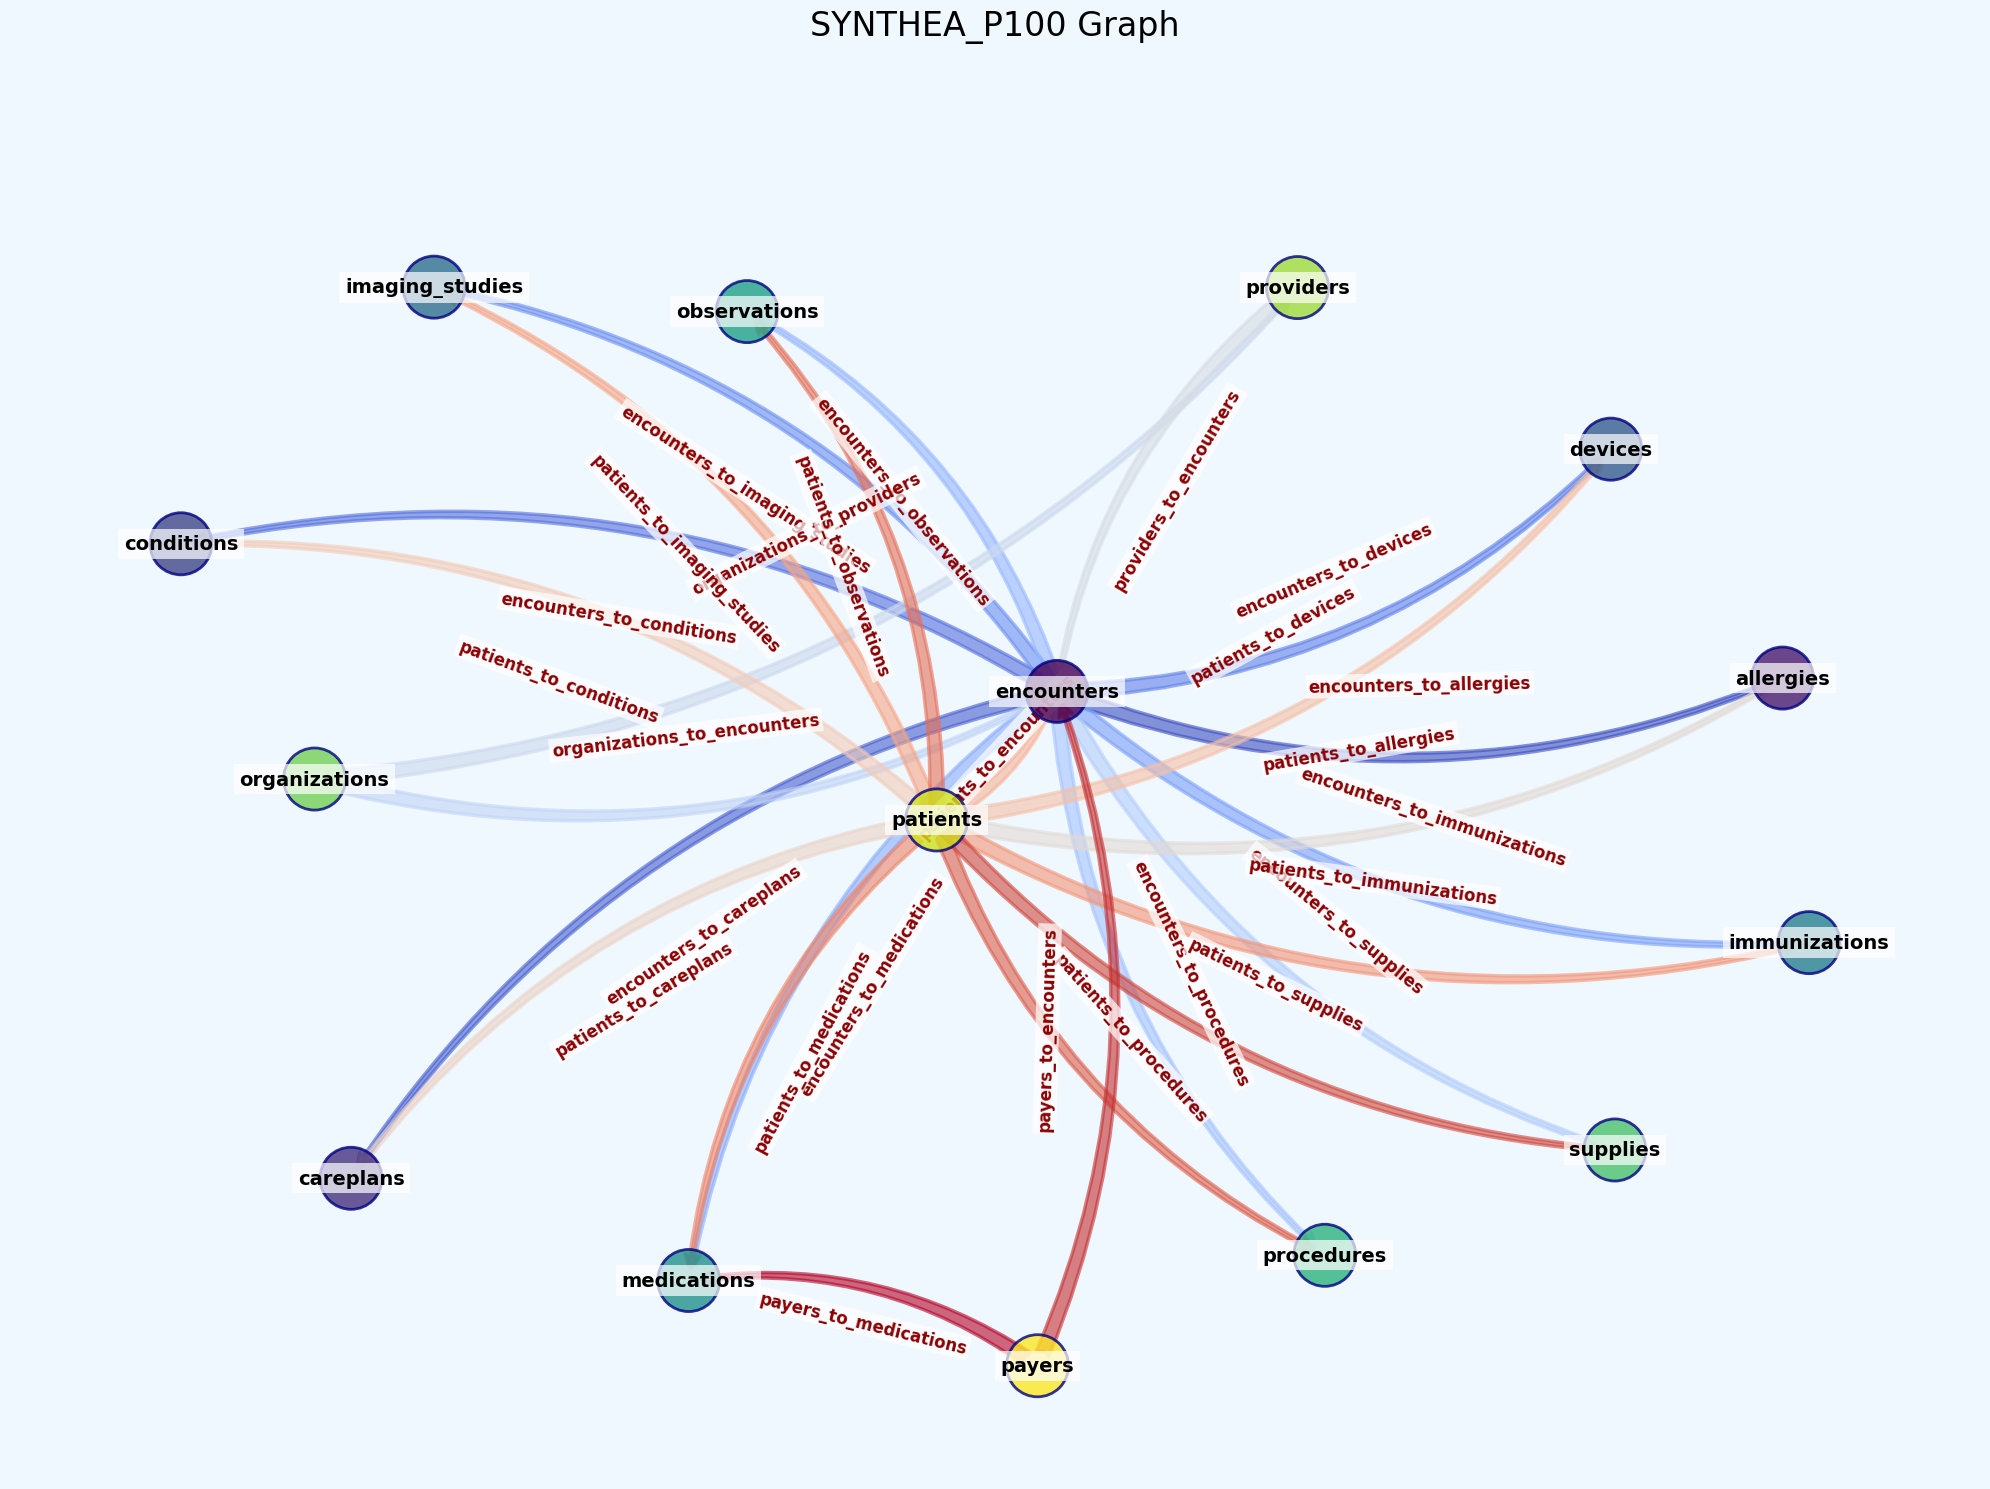

In [38]:
# Extract graph schema and edge definitions from schema data
graph_schema = arango_graph.schema["Graph Schema"][0]
edge_definitions = graph_schema["edge_definitions"]


# Create directed graph and add edges based on vertex collections
G_schema = nx.DiGraph()
for ed in edge_definitions:
    edge_collection = ed["edge_collection"]
    from_list = ed["from_vertex_collections"]
    to_list = ed["to_vertex_collections"]
    for f in from_list:
        for t in to_list:
            G_schema.add_edge(f, t, label=edge_collection)


# Set the layout for the graph visualization
pos = nx.spring_layout(G_schema, k=2, seed=42)


# Create figure with light blue background
plt.figure(figsize=(20, 15), facecolor='#f0f8ff')


# Draw nodes with color gradient
node_colors = plt.cm.viridis(np.linspace(0, 1, len(G_schema.nodes())))
nx.draw_networkx_nodes(
    G_schema, pos,
    node_size=2000,
    node_color=node_colors,
    edgecolors='navy',
    linewidths=2.0,
    alpha=0.8
)


# Draw edges with color gradient and curved arrows
edge_colors = plt.cm.coolwarm(np.linspace(0, 1, len(G_schema.edges())))
nx.draw_networkx_edges(
    G_schema, pos,
    arrowstyle='fancy',
    arrowsize=25,
    edge_color=edge_colors,
    width=2.5,
    connectionstyle='arc3,rad=0.2',
    alpha=0.6
)


# Add node labels with white background
nx.draw_networkx_labels(
    G_schema, pos,
    font_size=14,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=4)
)


# Add edge labels with white background
edge_labels = nx.get_edge_attributes(G_schema, 'label')
nx.draw_networkx_edge_labels(
    G_schema, pos,
    edge_labels=edge_labels,
    font_color='darkred',
    font_size=12,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
)

plt.title("SYNTHEA_P100 Graph", fontsize=24, pad=100)
plt.axis("off")
plt.tight_layout()


plt.grid(True, linestyle='--', alpha=0.5)

plt.show()



### Helper Functions


In [39]:
def print_table_message(text_list:List[str], headers: List[str] = [], tablefmt: str = "orgtbl")->None:
  """
  Prints a formatted message in a table format using tabulate library
  Parameters:
    text_list: List of strings to be displayed in the table
    headers: Optional list of column headers
    tablefmt: Table format style (default is "orgtbl")
  """
  print(tabulate([text_list],headers=headers,tablefmt=tablefmt))


def print_agent_tool(tool_name:str):
  # Get the terminal's width
  terminal_width = shutil.get_terminal_size().columns

  # Center the tool name and print it
  centered_message = f"{f'🩺 Using Tool: {tool_name}'.center(terminal_width)}"
  print(centered_message)


### Agent


#### Agent Global Vars

In [40]:
# Python code and results from text_to_nx_algorithm_to_text
text_to_nx_code = None
text_to_nx_results = None

#### Agent Tools


In [41]:
@tool
def text_to_nx_algorithm_to_text(modified_query:str) -> Dict:
    """
    This tool is available to invoke a NetworkX Algorithm on the ArangoDB Graph and also plot the graph.

    Args:
        modified_query: str = The modified query would be that version of initial user query that is free of typos and mistakes. The modified query is just a better constructed version of the initial query. The modified query should only contain the query that is related to networkX only.
    
    Returns:
        Returns a python dictionary having keys `natural_language_response` and `graph_operation_result`. The `natural_language_response` contains natural language summary of the value of dictionary key `graph_operation_result` and shown to the user. 
        The `graph_operation_result` contains the data fetched after the graph operation.
    """
    print_agent_tool(
        tool_name="text_to_nx_algorithm_to_text"
    )
    
    model = ChatGoogleGenerativeAI(temperature=0, model=GEMINI_FLASH_MODEL, api_key=GEMINI_API)

    print_table_message(
        text_list=["\n".join(modified_query[i:i+90] for i in range(0, len(modified_query), 90))],
        headers=["🔄 Updated User Query"],
        tablefmt="rounded_grid",
    )


    print_table_message(
        text_list=["⚙️ Generating NetworkX Algorithm... Please wait ⏳"],
        headers=[],
        tablefmt="outline"
    )
    


    unformatted_code = model.invoke(f"""
    I have a NetworkX Graph called `graph`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {modified_query}.

    Generate the Python Code required to answer the query using the `graph` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content
    
    # Extracting the code
    cleaned_code = re.sub(r"^```python\n|```$", "", unformatted_code, flags=re.MULTILINE).strip()
    
    # Printing the formatted code
    print_table_message(    
        text_list=[cleaned_code],
        headers=["📝 Generated NetworkX Algorithm"],
        tablefmt="rounded_grid"
    )

    print("\n")
    print_table_message(
        text_list=["🔍 Executing the NetworkX Algorithm... Please wait ⏳"],
        headers=[],
        tablefmt="outline"
    )

    global_vars = {
        "graph":graph,
        "nx":nx
    }

    local_vars = {}
    try:    
        exec(cleaned_code, global_vars, local_vars)
        # Copy the code that worked
        cleaned_code_copy = cleaned_code
    except Exception as e:
        print("\n")
        print_table_message(
            text_list=[f"⚠️ Error: Failed to Execute the Original NetworkX Algorithm."],
            headers=[],
            tablefmt="plain"
        )

        total_tries = 5
        while True:
            # Out of total_tries
            if(total_tries == 0):
                print("\n")
                print_table_message(
                    text_list=[f"❌ Failed to Resolve the NetworkX Algorithm after multiple attempts."],
                    headers=[],
                    tablefmt="heavy_outline"
                )
                return
            
            print("\n")
            print_table_message(
                text_list=[f"❌ Fixing the NetworkX Algorithm... {total_tries} Attempts Remaining."],
                headers=[],
                tablefmt="grid"
            )

            total_tries -= 1

            unformatted_corrected_code = model.invoke(f"""
                I have a NetworkX Graph called `graph`. It has the following schema: {arango_graph.schema}

                I have the following graph analysis query: {modified_query}.
                
                This is the python code that has been executed to do the graph analysis of the query.
                
                -------- <python_code> --------
                    {cleaned_code}
                -------- </python_code> --------
                
                And while executing the above Python code this is the error that has been encountered
                -------- <error> --------
                {e}
                -------- </error> --------
                Think step by step.
                
                General Instructions: 
                    Look for the wrong variable names. The NetworkX graph is called `graph` and networkX library has been imported like this `import networkx as nx`. 

                    Look for the wrong mention of collections, edges, attributes, field or any other name/variable that is not in the graph schema. 

                    Please make sure to properly go through the error, python code provided, schema and other information before you give the corrected code. 
                    
                    While solving the bug/error, it is important to take gaps for you to think properly.

                    In the new code only add the required comments and anything without the comments should not be added as this code would be taken as it is to be executed.

                    Only assume that networkx is installed, and other base python dependencies.

                    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

                    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

                    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

                    In the new code only add the required comments and anything without the comments should not be added as this code would be taken as it is to be executed. Only return the corrected code in front of `Your code:` that is mentioned below:
                    Your code:
                """).content
            
            formatted_corrected_code = re.sub(r"^```python\n|```$", "", unformatted_corrected_code, flags=re.MULTILINE).strip()

            # Shows the corrected code
            print_table_message(
                text_list=[formatted_corrected_code],
                headers=["🔧 Corrected NetworkX Algorithm"],
                tablefmt="rounded_grid"
            )


            print("\n")
            print_table_message(
                text_list=["⚙️ Executing the Corrected NetworkX Algorithm... Please wait ⏳"],
                headers=[],
                tablefmt="outline"
            )

            try:
                exec(formatted_corrected_code, global_vars, local_vars)
                cleaned_code_copy = formatted_corrected_code
                break
            except:
                print("\n")
                print_table_message(
                    text_list=[f"⚠️ Error: Failed to Execute the Corrected NetworkX Algorithm."],
                    headers=[],
                    tablefmt="fancy_grid" 
                )

                continue

    print_table_message(
        text_list=[f"✅ Successfully executed the NetworkX Algorithm"],
        headers=[],
        tablefmt="outline"
    )
    print("\n")

    nx_code_final_result = local_vars["FINAL_RESULT"]
    
    print_table_message(
        text_list=[nx_code_final_result],
        headers=["💻 NetworkX Algorithm Output"],
        tablefmt="rounded_grid"
    )

    global text_to_nx_code, text_to_nx_results
    text_to_nx_code = cleaned_code_copy
    text_to_nx_results = nx_code_final_result
    

    natural_language_response = model.invoke(f"""
        I have a NetworkX Graph called `graph`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {modified_query}.

        I have executed the following python code to help me answer my query:

        ---
        {cleaned_code_copy}
        ---

        The `FINAL_RESULT` variable is set to the following: {nx_code_final_result}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    print_table_message(
        text_list=["\n".join(natural_language_response[i:i+80] for i in range(0, len(natural_language_response), 80))],
        headers=[f"🔍 Answer to User Query"],
        tablefmt="rounded_grid"
    )
    return {
        "natural_language_response": natural_language_response,
        "graph_operation_result": nx_code_final_result
    }

@tool
def text_to_aql_to_text(query:str):
    """
    The tool is used to generate and return the results after applying the AQL on the SYNTHEA_P100 dataset. Modify the query to send that part from the initial user query for which AQL operation is required.

    Args: 
    query: str = The natural language query that would be used to convert to AQL queries and then return the result.

    Returns:
    Returns the string of AQL response containing information about the asked query
    """
    try:
        print_agent_tool(
            tool_name="text_to_aql"
        )

        print_table_message(
        text_list=["\n".join(query[i:i+80] for i in range(0, len(query), 80))],
        headers=["🔍 Query Received in AQL Tool"],
        tablefmt="fancy_grid"
        )

        aql_llm = ChatGoogleGenerativeAI(
            model=GEMINI_FLASH_LITE_MODEL,
            api_key=GEMINI_API,
            temperature=0.2,
        )

        print("\n")
        print_table_message(
            text_list=["🚀 Running the ArangoGraphQAChain"]
        )
        chain = ArangoGraphQAChain.from_llm(
            llm=aql_llm, 
            graph=arango_graph, 
            verbose=True,
            allow_dangerous_requests=True,
            )
        chain.return_aql_result = True
        aql_chain_response = chain.invoke([HumanMessage(content=query)])
        aql_result = aql_chain_response ["aql_result"]
        aql_summary = chain.invoke([HumanMessage(content=query)])["result"]

        print("\n")
        print_table_message(
            text_list=["\n".join(aql_summary[i:i+80] for i in range(0, len(aql_summary), 80))],
            headers=["🔍 AQL Response"],
            tablefmt="rounded_grid"
        )

        return aql_result
    except Exception as e:
        print_table_message(
            text_list=["Error in text_to_aql_to_text."],
            headers=["⚠️ Error"],
            tablefmt="heavy_grid"
        )

        return f"This is the error that has occured in the `text_to_aql_to_text` tool: \n{e}"


@tool
def plot_coordinates_on_map(coordinates, map_center=None, zoom_start=12) -> None:
    """
    Plots a list of coordinates on an interactive map with customizable marker colors and tags.

    Parameters:
        - coordinates: List of dictionaries with keys:
            'lat' (float): Latitude.
            'lon' (float): Longitude.
            'tag' (str, optional): A label or popup text for the marker.
            'marker_color' (str, optional): Color for the marker (default is 'blue').
        - map_center: Optional tuple (lat, lon) to center the map. If not provided, center is calculated.
        - zoom_start: Initial zoom level of the map.

    Returns:
        - None. The map is displayed immediately in the Jupyter Notebook.
    """
    try:
        print_agent_tool(tool_name="plot_coordinates_on_map")

        if not coordinates:
            print("\n")
            print_table_message(
                text_list=["⚠️ Missing coordinates. "],
                headers=["❌ Missing Tool Parameters"],
                tablefmt="fancy_grid"
            )
            return None

        # Conditionally calculate the map center
        if map_center is None:
            avg_lat = sum(coord['lat'] for coord in coordinates) / len(coordinates)
            avg_lon = sum(coord['lon'] for coord in coordinates) / len(coordinates)
            map_center = (avg_lat, avg_lon)

        # Create the Folium map
        m = folium.Map(location=map_center, zoom_start=zoom_start)

        # Add a marker for each coordinate with a custom color and tag
        for coord in coordinates:
            lat = coord['lat']
            lon = coord['lon']
            tag = coord.get('tag', '')
            marker_color = coord.get('marker_color', 'blue')
            folium.Marker(
                location=(lat, lon),
                popup=tag,
                icon=folium.Icon(color=marker_color)
            ).add_to(m)

        # Display the map
        display(m)
        return None
    
    except Exception as e:
        print_table_message(
            text_list=["Error in plot_coordinates_on_map."],
            headers=["⚠️ Error"],
            tablefmt="heavy_grid"
        )

        return f"This is the error that has occured in the `plot_coordinates_on_map` tool: \n{e}"

#### Agent executor function


In [29]:
def agent(user_query:str):
  """
    The function to call for the networkX agent.
  """
  networkx_agent_tools = [text_to_nx_algorithm_to_text, text_to_aql_to_text, plot_coordinates_on_map]
  networkx_agent_llm = ChatOpenAI(
    temperature=0,
    model=GPT_4O,
    api_key=OPENAI_API_KEY,
    verbose=True
  )
  
  agent_prompt = """
      You are the helpful networkX agent who has access to multiple tools. Below are the tools that you have access to with their role:
        1. `text_to_nx_algorithm_to_text`: This is the tool that would receive the modified version of the user query formatted and modified for the other LLM to properly understand. By modified query I mean to trim any part related to the visulisation from the initial user query and fix the typos and construct the query properly for the LLM to understand properly. The main and only function of this tool is to use AI to generate, implement, and show the results of the networkX algorithm to the user. To summarize, this tool is used to generate, execute and get the results from the graph(networkX) algorithms.

        2. `text_to_aql_to_text`: This is the tool that is specialised in taking in the queries and use the LLM to convert those queries into the AQL queries, fetches the result by executing the queries and return the reponse in the natural language. The tool can be used to perform AQL operations on SYNTHEA_P100 dataset stored in ArangoDB. Make sure that the output from this tool should be able to help the user and get all the information that the user is looking for. If you think the information does not match with the intent of the user query, use this tool by tweaking the initial user query to get the desired results. To summarize this tool is used to find information that are best to be find using the AQL.

        3. `plot_coordinates_on_map`: This is the tool that is uses the coordinates and plots them on the graph. You are free to use whenever you feel is the right time to use to enhance user experience. Please make sure to only use this tool once during the lifecycle. Also, only run this tool when you are completely sure that you have all the data for this tool or when the user has mentioned somewhere in the query. 

          Make sure the tags that have been passed in the coordinates dictionary should not just show the name of the entity but would also, show the a short description that would help the user know in what way the place is related to the patient. Keep this short and concise while making sure you mention the information.
          
          Thumb rule for using this tool is if you have coordinates, plot the map. You are also free to extract the data using other tools if required to plot the graph. Few places where you can do so and should do it are: 
          
          1. When the user wants a summary of the patient data.
          
          2. User wants to know information about an entity in a collection and that collection has available data for you to plot the graph. 
          
          3. You can also use this tool when the user has mentioned or inquired about any entity's location. You are free to experiment with this tool as long as it enhances the UX and UI. You are also allowed to get the coordinates and try if you can get some coordinates that would enhance the output of the overall user experience by plotting the graph. 

          4. If the user is asking about detailed/brief summary of a patient or related entities.

          5. If the user has asked info about the user's location for which the complete coordinates are present in the database.
          
          Make sure that any output you receive in this tool would only be used to plot the graphs and not to be used to include in the final answer. 
          
          Additionally, plot the data in such a way that each pointer looks visibly different from the other. 
          
          For this you can add different colors for each marker and only select the color that are available in this dictionary: 
          <colors_to_choose_from>
            {'pink', 'lightgray', 'blue', 'darkgreen', 'red', 'purple', 'green', 'darkred', 'cadetblue', 'lightgreen', 'gray', 'black', 'lightred', 'lightblue', 'white', 'beige', 'orange', 'darkblue', 'darkpurple'}
          </colors_to_choose_from>

      As of now you only have aforementioned tools, but more tools would be added later on. Do not run more than one tool at a time. At the end, if you are unable to fulfil any part of the user request, you can reply about that at the end. 

      Keep the tone natural and do not mention any apologetic/thankful messages. 
      
      Properly analyse the sequence of tool to run. 

      There would be cases where you need to run all the tools to reach to the final answer, so carefully examine the tools and their sequence.

      You are free to run single more than once to reach to the final and correct answer. 

      Before giving the end response, analyse the steps taken and the answer.

      Do not end your response with an open ended question unless it is very required. 
      
      Do not run more than one tool at once. Wait for the response from one tool before proceeding to the next tool.

      You are free to modify the query that you pass to each tool. This would enhance the efficiency and would reduce the chances of wrong repsonses from each tool. 

      Take time and pauses to think and analyse before using the tools, or giving the output to the user query.

      Do not mention about the tools you used during the process.
      
      Take gaps and proper time to properly use the tools. 

      If you get any queries that are not relevant to SYNTHEA_P100 dataset stored in ArangoDB or that can not be solved using networkX/graph algorithms then in that case you would politely deny the request.

      At the end, combine all the responses from the tools and answer the initial user query in the natural neutral tone. 
    """
  agent_executor = create_react_agent(
    tools=networkx_agent_tools,
    model=networkx_agent_llm, 
    prompt=agent_prompt,
  )
  networkX_agent_response = (agent_executor.invoke({"messages":[HumanMessage(content=user_query)]}))["messages"][-1].content
  print("\n")
  print_table_message(
    text_list=["\n".join(networkX_agent_response[i:i+90] for i in range(0, len(networkX_agent_response), 90))],
    headers=["🔍 Final Agent Response"],
    tablefmt="double_grid"
  )
  print("\n")
  return



### Application's starter and helper functions


In [42]:
def main(user_query:str):

  # MainSchema Class
  class MainSchema(BaseModel):
    # Type of the agent
    agent_type: str = Field(description="""The type of agent to be used to answer the user query. You can either choose `aql`, `networkX` or `hybrid`. If the user query best needs to be solved using AQL then select `aql`, if the user query needs to use networkX algorithms then use `networkX`, and if the user query needs a combination of both networkX and AQL then select `hybrid`. Please also note that if the user has mentioned anything about the visulaisation, plotting of the graph, or anything that involves some kind of visualisation, you will ignore that part of the query and then select the best method. It is because each of the specialised agent has their own visualisaion tool. Any other queries that are not related to the SYNTHEA_P100 dataset in the ArangoDB and also that can not be solved using `aql`, `networkX`, or `hybrid` specialised agents are considered irrelevant.""", default="")

    # The reason for selecting a specific agent type
    agent_type_reason: str = Field(description="The reason for the agent type. Please make sure to keep it short while informative for the end user.", default="")

    # Check the relevancy of the message
    is_relevant: bool = Field(description="If the user query is relevant to the dataset stored in ArangoDB then reply with True otherwise reply with False.", default=False)

    # When the message is not relevant
    irrelevant_message_response:str =  Field(description="Keep the tone neutral and tell in a simple short sentence your main purpose. No need to mention any apologies or open ended questions in your response.", default="")

  # LLM Parser
  main_parser = JsonOutputParser(pydantic_object=MainSchema)  
  
  # LLM Prompt
  main_prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. Should I find answer to the user's problem through aql, networkX, or hybrid. Please make sure that if the user query is not related to the SYNTHEA_P100 dataset stored in ArangoDB then you can deny the request and give a short message to the user. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": main_parser.get_format_instructions()},
  )


  # LLM
  main_model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
    verbose=True
  )

  try:
    # LangChain LCEL Chain
    main_chain = main_prompt | main_model | main_parser 
    main_chain_response = main_chain.invoke({"user_query":user_query})
    
    return main_chain_response
  except Exception as e:
    print(e)
    return "Something went wrong. Please try again later."


In [43]:
# Wrapper function of the main function
def main_wrapper(user_query:str):
  try:
    response = main(user_query=user_query)
    
    print_table_message(
    text_list=["\n".join([user_query[i:i+80] for i in range(0, len(user_query), 80)])],
    headers=["👨‍💻 User Query"],
    tablefmt="rounded_grid"
    )

    
    agent_selection = (response["agent_type"])
    agent_selection_reason = response["agent_type_reason"]
    is_relevant = response["is_relevant"]
    irrelevant_message_response = response["irrelevant_message_response"]

    
    # Checks for the irrelvant message
    if not is_relevant:
      print_table_message(
        text_list=["\n".join([irrelevant_message_response[i:i+80] for i in range(0, len(irrelevant_message_response), 80)])],
        headers=["🚨 Irrelevant Message Response"],
        tablefmt="rounded_grid"
      )
      return

    # Shows the agent selection and the reason for the selection
    print_table_message(
      text_list=[agent_selection,"\n".join([agent_selection_reason[i:i+80] for i in range(0, len(agent_selection_reason), 80)])],
      headers=["🤖 Query Type", "💡 Reason"],
      tablefmt="rounded_grid"
    )

    match agent_selection:
      case "aql" | "hybrid" | "networkX":
        agent(user_query=user_query)

      case _:
        print_table_message(
          text_list=["🚨 Unhandled case detected. Please try again with a different query. 🔄"],
          headers=[],
          tablefmt="heavy_grid" 
        )
  except Exception as e:
    print(e)
    print_table_message(
      text_list=["Something went wrong."],
      headers=["Error 🚩"],
      tablefmt="heavy_grid"
    )


In [44]:
# The function that starts the execution of the whole program
main_wrapper("Get me the brief summary of the personal info of the patient whose id is 01fd0320-1260-3613-95fb-7703f53e6a08 and how many careplans does this patient has?")

╭──────────────────────────────────────────────────────────────────────────────────╮
│ 👨‍💻 User Query                                                                    │
├──────────────────────────────────────────────────────────────────────────────────┤
│ Get me the brief summary of the personal info of the patient whose id is 01fd032 │
│ 0-1260-3613-95fb-7703f53e6a08 and how many careplans does this patient has?      │
╰──────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ 🤖 Query Type   │ 💡 Reason                                                                        │
├─────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ aql             │ The query requires fetching patient information and counting related care plans, │
│                 │  which can be efficiently done using AQL.                  



╔════════════════════════════════════════════════════════════════════════════════════════════╗
║ 🔍 Final Agent Response                                                                    ║
╠════════════════════════════════════════════════════════════════════════════════════════════╣
║ The patient with ID **01fd0320-1260-3613-95fb-7703f53e6a08** is named **Frankie174 Schinne ║
║ r682**. Here is a brief summary of their personal information:                             ║
║                                                                                            ║
║ - **Birthdate:** August 10                                                                 ║
║ , 1951                                                                                     ║
║ - **Gender:** Male                                                                         ║
║ - **Race:** White                                                                          ║
║ - **Ethnicity:** Non-Hispanic                  

In [45]:
main_wrapper("Does the patient whose SSN is this: 999-95-7221 has any allergy to molds, and can you list all the allergies?")

╭──────────────────────────────────────────────────────────────────────────────────╮
│ 👨‍💻 User Query                                                                    │
├──────────────────────────────────────────────────────────────────────────────────┤
│ Does the patient whose SSN is this: 999-95-7221 has any allergy to molds, and ca │
│ n you list all the allergies?                                                    │
╰──────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ 🤖 Query Type   │ 💡 Reason                                                                        │
├─────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ aql             │ The query requires filtering and retrieving patient allergy information based on │
│                 │  SSN, which can be efficiently done using AQL.             

In [46]:
main_wrapper("Identify the top 5 most connected providers and can you get me the details of the providers based on that")

╭──────────────────────────────────────────────────────────────────────────────────╮
│ 👨‍💻 User Query                                                                    │
├──────────────────────────────────────────────────────────────────────────────────┤
│ Identify the top 5 most connected providers and can you get me the details of th │
│ e providers based on that                                                        │
╰──────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ 🤖 Query Type   │ 💡 Reason                                                                        │
├─────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ networkX        │ The query asks for the most connected providers, which requires graph analysis t │
│                 │ o determine the degree of each node (provider) in the netwo

### Code Correction Technique In Action

In [31]:
main_wrapper("Identify the top 5 most connected patients and can you get me their full names as well")

╭──────────────────────────────────────────────────────────────────────────────────╮
│ 👨‍💻 User Query                                                                    │
├──────────────────────────────────────────────────────────────────────────────────┤
│ Identify the top 5 most connected patients and can you get me their full names a │
│ s well                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ 🤖 Query Type   │ 💡 Reason                                                                        │
├─────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ networkX        │ The query asks for the most connected patients, which requires graph analysis to │
│                 │  determine the degree of each patient node. NetworkX is sui